In [1]:
import tempo_utils
import numpy
import matplotlib.pyplot as plt

First, read in some TOAs from a tim file.

In [2]:
toas = tempo_utils.read_toa_file("shared/tempo_utils_example/1946+2052.tim")

The TOA file is read into a list of TOA objects. However, tim files can contain lines that are not TOAs, for example in the tim file we just read in, the first 2 lines are not TOAs. You can view a TOA simply by printing it.

In [3]:
print toas[0]

MODE 1


tempo_utils provides the ability to test whether an object in the list is a valid TOA or not

In [4]:
print toas[0].is_toa()

False


The minimum TOA information needed is the time-of-arrival, the telescope used to observe, the frequency, and an uncertainty for the TOA measurement. Additional information can be specified for each TOA, but we will just worry about the typical TOA parameters. To see these values for the first TOA (which is the third object in the TOA list), we can print the following.

In [5]:
print "time-of-arrival =",toas[2].mjd
print "frequency (MHz)=",toas[2].freq
print "TOA is from telescope with tempo code =",toas[2].site
print "TOA uncertainty (microseconds) =",toas[2].error

time-of-arrival = 57953.2271459
frequency (MHz)= 1456.117
TOA is from telescope with tempo code = 3
TOA uncertainty (microseconds) = 44.753


tempo_utils interacts with a par file in one of two ways. One is to open a par file when "run_tempo" is run, see below. The other is to have a list of strings which would be in the par file. I find this second option to be more generally useful, since it allows for easier editing of the lines. To get such a list, we can just start from an existing par file as follows.

In [6]:
parlines = open("shared/tempo_utils_example/1946+2052_DDGR.par").readlines()

In [7]:
print parlines

['PSR              J1946+2052_DDGR\n', 'RAJ      19:46:14.16700000\n', 'DECJ      20:52:25.0000001\n', 'F0     58.9616546266521837  1  0.0000000010387190\n', 'F1     -5.148083624682D-15  1  9.195416804133D-16\n', 'PEPOCH        57982.080242\n', 'START            57953.226\n', 'FINISH           58007.094\n', 'DM               93.962745  1            0.002377\n', 'SOLARN0              10.00\n', 'EPHEM               DE436\n', 'CLK                 TT(BIPM2015)                    \n', 'UNITS               TDB\n', 'TIMEEPH             FB90\n', 'T2CMETHOD           TEMPO\n', 'CORRECT_TROPOSPHERE N\n', 'PLANET_SHAPIRO      N\n', 'DILATEFREQ          N\n', 'NTOA                   796\n', 'TRES                 93.95\n', 'TZRMJD  57982.08029684945738\n', 'TZRFRQ            1579.782\n', 'TZRSITE                  AO\n', 'MODE                     1\n', 'NITS                     1\n', 'BINARY            DDGR    \n', 'A1             1.154477721  1         0.000011956\n', 'E             0.0638321181  1

One we have the TOAs and the par file lines, we can have tempo_utils execute a tempo run using "run_tempo" as follows. This returns some information on the chi^2, number of degrees of freedom, the rms of the residuals, and the lines for a new par file from the fit.

In [8]:
(base_chi2,base_ndof,base_rms,base_outparlines) = tempo_utils.run_tempo(toas,parlines, get_output_par=True)

Let's have a look at these output parameters for this fit.

In [9]:
print base_chi2

1343.87


In [10]:
print base_ndof

782.0


In [11]:
print base_rms

93.952


In [12]:
print base_outparlines

['PSR              J1946+2052_DDGR\n', 'RAJ      19:46:14.16700000\n', 'DECJ      20:52:25.0000001\n', 'F0     58.9616546266525177  1  0.0000000010386985\n', 'F1     -5.147976446553D-15  1  9.200320706447D-16\n', 'PEPOCH        57982.080242\n', 'START            57953.226\n', 'FINISH           58007.094\n', 'DM               93.962746  1            0.002377\n', 'SOLARN0              10.00\n', 'EPHEM               DE436\n', 'CLK                 TT(BIPM2015)                    \n', 'UNITS               TDB\n', 'TIMEEPH             FB90\n', 'T2CMETHOD           TEMPO\n', 'CORRECT_TROPOSPHERE N\n', 'PLANET_SHAPIRO      N\n', 'DILATEFREQ          N\n', 'NTOA                   796\n', 'TRES                 93.95\n', 'TZRMJD  57982.08029684945619\n', 'TZRFRQ            1579.782\n', 'TZRSITE                  AO\n', 'MODE                     1\n', 'NITS                     1\n', 'BINARY            DDGR    \n', 'A1             1.154478423  1         0.000017214\n', 'E             0.0638321264  1

We can calculate the reduce chi^2 easily enough by dividing the chi^2 by the number of degrees of freedom.

In [13]:
print base_chi2/base_ndof

1.71850383632


Now let's go through a particular example for a situation where tempo_utils is useful. In this case, we have a double neutron star system for which we have had a clear detection of the advance in periastron passage (omega dot) which tells us the total mass of the system. A useful binary model that exists in TEMPO for such systems is the DDGR model which fits for the total mass and the mass of the companion and assumes GR is correct to calculate a variety of effects that might be measurable. In the par file above, it tells us that the companion mass (M2) has been measured to be 1.23(7) solar masses. However, tempo does not give accurate error measurements in some cases as we demonstrate below. We will grid over a range of MTOT and M2 values and calculate chi^2 using tempo. Note that we are not fitting for these two parameters, but instead are just setting them and getting chi^2. The following loop will take a few minutes to get the chi^2 values.

In [16]:
chi2map = []
m2s = numpy.arange(1.2,1.6,0.005)
mtots = numpy.arange(2.450,2.535,0.005)
for mtot in mtots:
    rowofchi2s = []
    print mtot
    for m2 in m2s:
        #Remove the current MTOT and M2 lines from the par lines.
        parlines = [l for l in parlines if not l.startswith("MTOT")]
        parlines = [l for l in parlines if not l.startswith("M2")]
        #Insert the new MTOT and M2 values
        parlines.append('MTOT %f 0\n' % mtot)
        parlines.append('M2 %f 0\n' % m2)
        (new_chi2,new_ndof,new_rms,new_outparlines) = tempo_utils.run_tempo(toas,parlines, get_output_par=True)
#        print mtot,m2,new_chi2
        rowofchi2s.append(new_chi2)
    chi2map.append(rowofchi2s)

2.45
2.455
2.46
2.465
2.47
2.475
2.48
2.485
2.49
2.495
2.5
2.505
2.51
2.515
2.52
2.525
2.53


Convert the chi^2 values to be a numpy array.

In [17]:
chi2map_np = numpy.array(chi2map)

Change the values of the chi^2 values mostly for plotting purposes.

In [18]:
newchi2map = 1.0/(numpy.exp(chi2map_np - base_chi2))

Now let's look at the plot, note how asymmetric the chi^2 is in M2, this means that the tempo returned error for M2 is not accurate.

In [19]:
plt.pcolormesh(m2s,mtots,newchi2map)
plt.ylabel("MTOT")
plt.xlabel("M2")

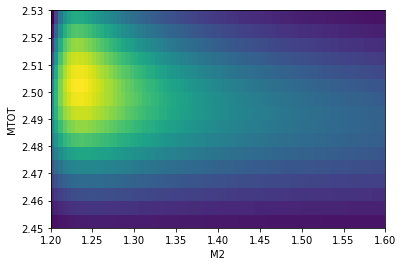

In [20]:
plt.show()

In [21]:
plt.plot(newchi2map[9])

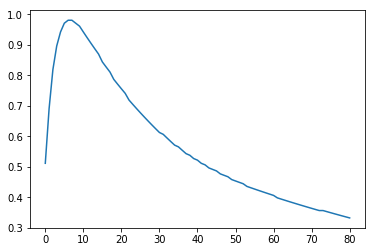

In [22]:
plt.show()